In [66]:
import sys
sys.chdir('../')

import numpy as np
import pandas as pd
import random

from src.utils import *

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import Embedding, LSTM, TimeDistributed
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import losses
from keras import regularizers
from keras.constraints import max_norm
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.models import load_model

import time

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold

from xgboost import XGBClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
Data_X_train = pd.read_csv('data/challenge_fichier_dentrees_dentrainement_challenge_nba/train.csv')
Data_Y_train = pd.read_csv('data/challenge_fichier_de_sortie_dentrainement_challenge_nba.csv', sep=';')

In [3]:
Data_X_train = feature_engineering(Data_X_train)

100%|██████████| 1440/1440 [03:19<00:00,  7.23it/s] 


In [4]:
X = Data_X_train.as_matrix()[:,1:]
Y = Data_Y_train.as_matrix()[:,1:]
Y_train = np_utils.to_categorical(Y, 2)

In [6]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)

In [47]:
def kfold_print(skf_splitter, X, Y, create_model_func, epochs, batch_size, verbose, last_layer):
    accs_train_svm = []
    accs_val_svm = []
    
    accs_train_xgb = []
    accs_val_xgb = []
    
    for train, val in skf.split(X, Y):
        model = create_model_func()
        Y_train = np_utils.to_categorical(Y[train], 2)
        Y_val = np_utils.to_categorical(Y[val], 2)
        model.fit(X[train], Y_train, epochs = epochs, batch_size = batch_size, verbose = verbose)

        
        extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[last_layer].output])
        X_features = extract_cnn_features([X, 0])[0]
        
        
        clf = SVC(kernel = 'rbf')
        clf.fit(X_features[train], Y[train].flatten())
        acc_train = clf.score(X_features[train], Y[train].flatten())
        accs_train_svm.append(acc_train)
        acc_val = clf.score(X_features[val], Y[val].flatten())
        accs_val_svm.append(acc_val)
        print('Training SVM: {0:.2f} - {1:.2f}'.format(100*acc_train, 100*acc_val))
        
        clf = XGBClassifier(n_estimators = 100, 
                            max_depth = 3, 
                            min_child_weight = 5,
                            subsample = 0.7, 
                            colsample_bytree = 0.7, 
                            silent = True)
        clf.fit(X_features[train], Y[train].flatten())
        acc_train = clf.score(X_features[train], Y[train].flatten())
        accs_train_xgb.append(acc_train)
        acc_val = clf.score(X_features[val], Y[val].flatten())
        accs_val_xgb.append(acc_val)
        print('Training XGBoost: {0:.2f} - {1:.2f}'.format(100*acc_train, 100*acc_val))

        
    print('SVM')
    print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*np.mean(accs_train_svm), 
                                                                  100*np.std(accs_train_svm)))
    print('--- Mean cv val score: {0:.2f}% +/- {1:.2f}%'.format(100*np.mean(accs_val_svm), 
                                                                  100*np.std(accs_val_svm)))
    
    print('XGBoost')
    print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*np.mean(accs_train_xgb), 
                                                                  100*np.std(accs_train_xgb)))
    print('--- Mean cv val score: {0:.2f}% +/- {1:.2f}%'.format(100*np.mean(accs_val_xgb), 
                                                                  100*np.std(accs_val_xgb)))

# 15 seconds

In [62]:
X_train = X.reshape((len(X), 14, 15, -1), order = 'F')
X_train = X_train.mean(axis = 2)

**LSTM 1**

In [48]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(30, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_1.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(30, 
                        input_shape = (14, 96)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 20,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 72.54 - 72.38
Training XGBoost: 73.23 - 73.09
Training SVM: 72.79 - 72.18
Training XGBoost: 73.62 - 72.14
Training SVM: 72.76 - 71.29
Training XGBoost: 73.78 - 71.73
Training SVM: 72.39 - 72.41
Training XGBoost: 73.81 - 70.97
Training SVM: 73.79 - 68.85
Training XGBoost: 74.56 - 68.81
SVM
--- Mean cv train score: 72.86% +/- 0.49%
--- Mean cv val score: 71.42% +/- 1.35%
XGBoost
--- Mean cv train score: 73.80% +/- 0.43%
--- Mean cv val score: 71.35% +/- 1.44%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30)                15240     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 15,902
Trainable params: 15,902
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 72.05% +/- 0.23%
--- Mean cv test score: 71.76% +/- 0.73%
SVM
--- Mean cv train score: 72.06% +/- 0.24%
--- Mean cv test score: 71.87% +/- 0.50%
XGBoost
--- Mean cv train score: 75.54% +/- 0.39%
--- Mean cv test score: 71.99%

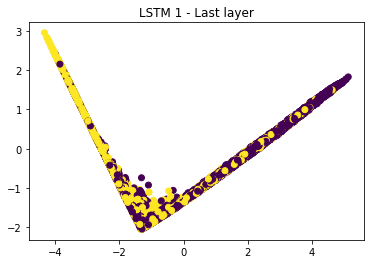

In [76]:
model = load_model('models/LSTMs/lstm_1.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 1 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 2**

In [7]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                29400     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 42        
Total params: 30,462
Trainable params: 30,462
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 73.40% +/- 0.08%
--- Mean cv test score: 73.22% +/- 0.48%
SVM
--- Mean cv train score: 73.39% +/- 0.12%
--- Mean cv test score: 73.31% +/- 0.40%
XGBoost
--- Mean cv train score: 77.12% +/- 0.27%
--- Mean cv test score: 73.25%

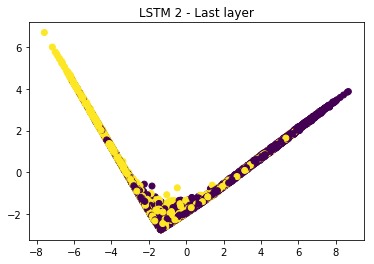

In [77]:
model = load_model('models/LSTMs/lstm_2.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 2 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 3**

In [49]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(75, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_3.h5')


def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(30, 
                        input_shape = (14, 96)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 20,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 72.38 - 72.81
Training XGBoost: 72.91 - 73.01
Training SVM: 72.69 - 72.38
Training XGBoost: 73.99 - 72.73
Training SVM: 72.43 - 71.53
Training XGBoost: 74.22 - 71.41
Training SVM: 72.69 - 72.21
Training XGBoost: 73.91 - 71.97
Training SVM: 73.33 - 68.10
Training XGBoost: 74.40 - 68.18
SVM
--- Mean cv train score: 72.70% +/- 0.34%
--- Mean cv val score: 71.41% +/- 1.70%
XGBoost
--- Mean cv train score: 73.88% +/- 0.52%
--- Mean cv val score: 71.46% +/- 1.74%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                51600     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1520      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 42        
Total params: 53,162
Trainable params: 53,162
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 74.21% +/- 0.28%
--- Mean cv test score: 74.13% +/- 1.02%
SVM
--- Mean cv train score: 74.42% +/- 0.18%
--- Mean cv test score: 74.24% +/- 1.03%
XGBoost
--- Mean cv train score: 77.64% +/- 0.25%
--- Mean cv test score: 74.06%

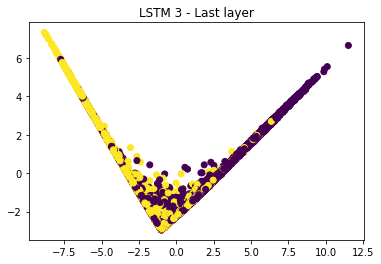

In [78]:
model = load_model('models/LSTMs/lstm_3.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 3 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 4**

In [50]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_4.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, 
                        input_shape = (14, 96)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 20,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model


kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 73.45 - 71.94
Training XGBoost: 73.88 - 72.06
Training SVM: 73.96 - 72.02
Training XGBoost: 74.89 - 71.98
Training SVM: 73.62 - 70.97
Training XGBoost: 75.20 - 71.53
Training SVM: 73.55 - 71.93
Training XGBoost: 74.68 - 72.29
Training SVM: 74.78 - 69.05
Training XGBoost: 76.23 - 68.66
SVM
--- Mean cv train score: 73.87% +/- 0.48%
--- Mean cv val score: 71.18% +/- 1.13%
XGBoost
--- Mean cv train score: 74.98% +/- 0.76%
--- Mean cv val score: 71.30% +/- 1.35%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               78800     
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 42        
Total params: 80,862
Trainable params: 80,862
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 76.26% +/- 0.17%
--- Mean cv test score: 76.23% +/- 0.68%
SVM
--- Mean cv train score: 76.19% +/- 0.12%
--- Mean cv test score: 76.05% +/- 0.70%
XGBoost
--- Mean cv train score: 79.30% +/- 0.15%
--- Mean cv test score: 75.76%

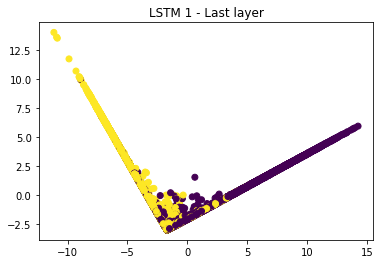

In [79]:
model = load_model('models/LSTMs/lstm_4.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 1 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 5**

In [10]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(30, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_5.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30)                15240     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 62        
Total params: 15,302
Trainable params: 15,302
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 72.85% +/- 0.25%
--- Mean cv test score: 72.71% +/- 0.76%
SVM
--- Mean cv train score: 72.67% +/- 0.22%
--- Mean cv test score: 72.30% +/- 0.75%
XGBoost
--- Mean cv train score: 75.47% +/- 1.86%
--- Mean cv test score: 72.26% +/- 0.74%


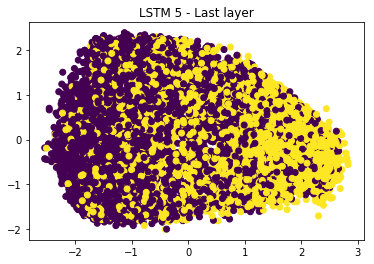

In [80]:
model = load_model('models/LSTMs/lstm_5.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 5 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 6**

In [63]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_6.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, 
                        input_shape = (14, 96)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 1)

Training SVM: 74.05 - 72.73
Training XGBoost: 77.23 - 72.26
Training SVM: 74.73 - 72.02
Training XGBoost: 78.09 - 71.30
Training SVM: 75.00 - 70.34
Training XGBoost: 78.42 - 68.47
Training SVM: 74.63 - 71.93
Training XGBoost: 77.76 - 71.41
Training SVM: 75.47 - 69.49
Training XGBoost: 78.73 - 69.17
SVM
--- Mean cv train score: 74.78% +/- 0.47%
--- Mean cv val score: 71.30% +/- 1.20%
XGBoost
--- Mean cv train score: 78.05% +/- 0.52%
--- Mean cv val score: 70.52% +/- 1.45%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                29400     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 102       
Total params: 29,502
Trainable params: 29,502
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 74.65% +/- 0.27%
--- Mean cv test score: 74.35% +/- 1.21%
SVM
--- Mean cv train score: 74.46% +/- 0.22%
--- Mean cv test score: 73.54% +/- 0.62%
XGBoost
--- Mean cv train score: 77.77% +/- 1.68%
--- Mean cv test score: 73.85% +/- 0.78%


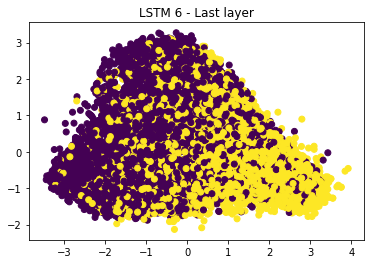

In [81]:
model = load_model('models/LSTMs/lstm_6.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 6 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 7**

In [64]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(75, 
#                     input_shape = (11, 96), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_7.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(75, 
                        input_shape = (14, 96)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 1)

Training SVM: 75.77 - 72.50
Training XGBoost: 78.76 - 72.10
Training SVM: 76.75 - 71.30
Training XGBoost: 79.10 - 70.67
Training SVM: 76.08 - 70.74
Training XGBoost: 78.87 - 70.54
Training SVM: 75.66 - 71.97
Training XGBoost: 78.72 - 70.89
Training SVM: 77.85 - 68.89
Training XGBoost: 81.20 - 68.54
SVM
--- Mean cv train score: 76.42% +/- 0.81%
--- Mean cv val score: 71.08% +/- 1.24%
XGBoost
--- Mean cv train score: 79.33% +/- 0.94%
--- Mean cv val score: 70.55% +/- 1.15%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 75)                51600     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 152       
Total params: 51,752
Trainable params: 51,752
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 77.53% +/- 0.24%
--- Mean cv test score: 76.98% +/- 0.84%
SVM
--- Mean cv train score: 77.93% +/- 0.22%
--- Mean cv test score: 76.54% +/- 0.72%
XGBoost
--- Mean cv train score: 79.76% +/- 1.65%
--- Mean cv test score: 75.87% +/- 1.05%


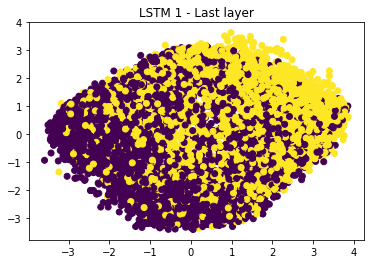

In [82]:
model = load_model('models/LSTMs/lstm_7.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 7 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

# 10 seconds

In [54]:
X_train = X.reshape((len(X), 14, 10, -1), order = 'F')
X_train = X_train.mean(axis = 2)

**LSTM 8**

In [14]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(30, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_8.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 30)                21000     
_________________________________________________________________
dense_12 (Dense)             (None, 20)                620       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 42        
Total params: 21,662
Trainable params: 21,662
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 71.88% +/- 0.17%
--- Mean cv test score: 71.64% +/- 0.39%
SVM
--- Mean cv train score: 71.92% +/- 0.14%
--- Mean cv test score: 71.84% +/- 0.59%
XGBoost
--- Mean cv train score: 74.94% +/- 0.10%
--- Mean cv test score: 71.09%

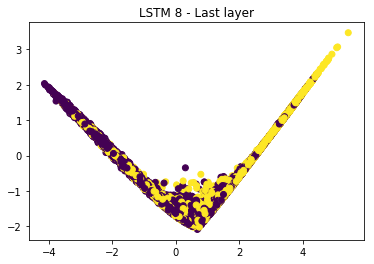

In [84]:
model = load_model('models/LSTMs/lstm_8.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 8 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 9**

In [15]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_9.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                39000     
_________________________________________________________________
dense_14 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 42        
Total params: 40,062
Trainable params: 40,062
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 73.61% +/- 0.14%
--- Mean cv test score: 73.62% +/- 0.65%
SVM
--- Mean cv train score: 73.59% +/- 0.19%
--- Mean cv test score: 73.49% +/- 0.89%
XGBoost
--- Mean cv train score: 76.99% +/- 0.21%
--- Mean cv test score: 73.19%

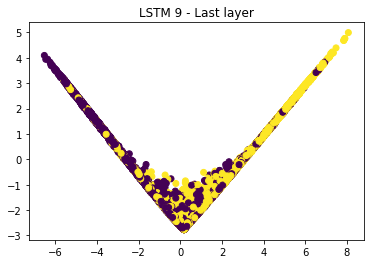

In [85]:
model = load_model('models/LSTMs/lstm_9.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 9 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 10**

In [55]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(75, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_10.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(75, 
                        input_shape = (14, 144)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 20,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 72.79 - 72.77
Training XGBoost: 73.24 - 72.85
Training SVM: 73.59 - 72.69
Training XGBoost: 74.17 - 72.42
Training SVM: 73.12 - 71.13
Training XGBoost: 73.75 - 71.09
Training SVM: 73.11 - 72.09
Training XGBoost: 73.98 - 71.97
Training SVM: 73.82 - 69.21
Training XGBoost: 74.50 - 68.97
SVM
--- Mean cv train score: 73.29% +/- 0.37%
--- Mean cv val score: 71.58% +/- 1.32%
XGBoost
--- Mean cv train score: 73.93% +/- 0.42%
--- Mean cv val score: 71.46% +/- 1.37%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 75)                66000     
_________________________________________________________________
dense_16 (Dense)             (None, 20)                1520      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 42        
Total params: 67,562
Trainable params: 67,562
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 74.16% +/- 0.23%
--- Mean cv test score: 74.15% +/- 0.87%
SVM
--- Mean cv train score: 74.27% +/- 0.22%
--- Mean cv test score: 74.21% +/- 0.68%
XGBoost
--- Mean cv train score: 77.76% +/- 0.15%
--- Mean cv test score: 73.83%

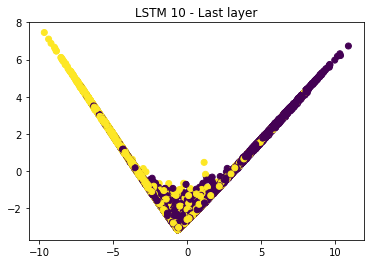

In [86]:
model = load_model('models/LSTMs/lstm_10.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 10 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 11**

In [56]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 20,
#                     activation = 'relu'))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_11.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, 
                        input_shape = (14, 144)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 20,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 73.32 - 72.22
Training XGBoost: 73.72 - 72.46
Training SVM: 74.10 - 72.54
Training XGBoost: 74.98 - 72.42
Training SVM: 73.57 - 70.97
Training XGBoost: 74.31 - 71.13
Training SVM: 73.47 - 72.29
Training XGBoost: 74.52 - 72.29
Training SVM: 73.92 - 69.97
Training XGBoost: 74.64 - 69.53
SVM
--- Mean cv train score: 73.68% +/- 0.29%
--- Mean cv val score: 71.60% +/- 0.98%
XGBoost
--- Mean cv train score: 74.43% +/- 0.42%
--- Mean cv val score: 71.56% +/- 1.13%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               98000     
_________________________________________________________________
dense_18 (Dense)             (None, 20)                2020      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 42        
Total params: 100,062
Trainable params: 100,062
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 76.78% +/- 0.10%
--- Mean cv test score: 76.50% +/- 0.66%
SVM
--- Mean cv train score: 76.56% +/- 0.19%
--- Mean cv test score: 76.50% +/- 0.69%
XGBoost
--- Mean cv train score: 80.14% +/- 0.17%
--- Mean cv test score: 76.3

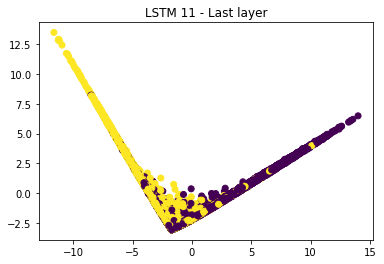

In [87]:
model = load_model('models/LSTMs/lstm_11.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 11 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 12**

In [18]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(30, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_12.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 30)                21000     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 62        
Total params: 21,062
Trainable params: 21,062
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 72.37% +/- 0.20%
--- Mean cv test score: 72.13% +/- 0.39%
SVM
--- Mean cv train score: 72.41% +/- 0.13%
--- Mean cv test score: 71.88% +/- 0.55%
XGBoost
--- Mean cv train score: 73.94% +/- 1.03%
--- Mean cv test score: 71.97% +/- 0.61%


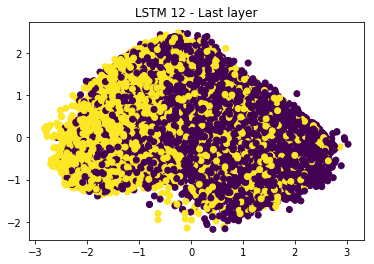

In [88]:
model = load_model('models/LSTMs/lstm_12.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 12 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

**LSTM 13**

In [19]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, 
#                     input_shape = (11, 144), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 2, 
#                 activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_13.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50)                39000     
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 102       
Total params: 39,102
Trainable params: 39,102
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 73.83% +/- 0.16%
--- Mean cv test score: 73.43% +/- 0.45%
SVM
--- Mean cv train score: 73.26% +/- 0.11%
--- Mean cv test score: 72.37% +/- 0.67%
XGBoost
--- Mean cv train score: 76.71% +/- 1.66%
--- Mean cv test score: 72.81% +/- 0.36%


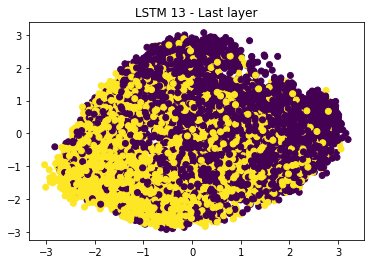

In [89]:
model = load_model('models/LSTMs/lstm_13.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[0].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 13 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

# 20 seconds

In [65]:
X_train = X.reshape((len(X), 14, 20, -1), order = 'F')
X_train = X_train.mean(axis = 2)

**LSTM 14**

In [59]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(100, 
#                     input_shape = (11, 72), 
#                     dropout = 0.75))
# lstm_model.add(Dense(units = 75, 
#                 activation='relu'))
# lstm_model.add(Dropout(0.75))
# lstm_model.add(Dense(units = 2, 
#                     activation='softmax'))

# lstm_model.compile(loss = losses.categorical_crossentropy,
#                      optimizer = 'adam',
#                      metrics = ['accuracy'])
# training = lstm_model.fit(X_train, Y_train, epochs = 200, batch_size = 32, verbose = False)

# lstm_model.save('models/LSTMs/lstm_14.h5')

def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, 
                        input_shape = (14, 72)))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75,
                        activation = 'relu'))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))

    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 25, 32, False, 2)

Training SVM: 72.80 - 72.34
Training XGBoost: 73.67 - 72.81
Training SVM: 73.51 - 72.58
Training XGBoost: 74.20 - 72.18
Training SVM: 73.86 - 70.38
Training XGBoost: 74.34 - 70.70
Training SVM: 72.83 - 70.82
Training XGBoost: 74.01 - 72.09
Training SVM: 73.81 - 69.73
Training XGBoost: 74.45 - 69.01
SVM
--- Mean cv train score: 73.36% +/- 0.46%
--- Mean cv val score: 71.17% +/- 1.11%
XGBoost
--- Mean cv train score: 74.13% +/- 0.27%
--- Mean cv val score: 71.36% +/- 1.36%


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               69200     
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 152       
Total params: 76,927
Trainable params: 76,927
Non-trainable params: 0
_________________________________________________________________
Logistic Regression
--- Mean cv train score: 75.18% +/- 0.15%
--- Mean cv test score: 74.75% +/- 1.18%
SVM
--- Mean cv train score: 75.24% +/- 0.28%
--- Mean cv test score: 75.02% +/- 0.74%
XGBoost
--- Mean cv train score: 80.89% +/- 0.20%
--- Mean cv test score: 75.12%

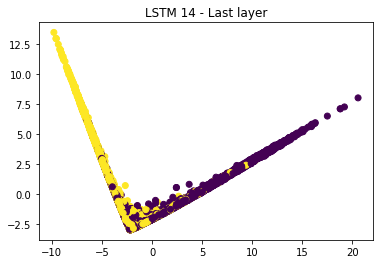

In [11]:
model = load_model('models/LSTMs/lstm_14.h5')
model.summary()

extract_cnn_features = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[1].output])
X_train_features = extract_cnn_features([X_train, 0])[0]
X_train_features[0,:]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())
plt.title('LSTM 14 - Last layer')

clf = LogisticRegression()
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('Logistic Regression')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = SVC(kernel = 'rbf')
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('SVM')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

clf = XGBClassifier(n_estimators = 1000, max_depth = 2)
scores = cross_validate(clf, X_train_features, Y.flatten(), cv = 5)
print('XGBoost')
print('--- Mean cv train score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['train_score'].mean(), 
                                                              100*scores['train_score'].std()))
print('--- Mean cv test score: {0:.2f}% +/- {1:.2f}%'.format(100*scores['test_score'].mean(), 
                                                             100*scores['test_score'].std()))

In [7]:
Data_X_test = pd.read_csv('data/challenge_fichiers_dentrees_de_test_challenge_nba/test.csv')
X_test = Data_X_test.as_matrix()[:,1:]
X_test = X_test.reshape((len(X_test), 11, 20, -1), order = 'F')
X_test = X_test.mean(axis = 2)

Text(0.5,1,'LSTM 14 - Last layer')

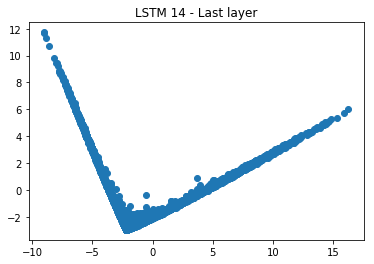

In [10]:
X_test_features = extract_cnn_features([X_test, 0])[0]

X_proj = proj.transform(X_test_features)

plt.scatter(X_proj[:,0], X_proj[:,1])
plt.title('LSTM 14 - Last layer')

**M LSTM 1**

In [60]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(150, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False, 4)

Training SVM: 72.91 - 72.14
Training XGBoost: 73.68 - 72.73
Training SVM: 72.84 - 72.97
Training XGBoost: 73.39 - 72.97
Training SVM: 73.03 - 71.17
Training XGBoost: 74.05 - 70.97
Training SVM: 72.75 - 72.29
Training XGBoost: 74.11 - 72.29
Training SVM: 73.52 - 69.49
Training XGBoost: 74.61 - 69.13
SVM
--- Mean cv train score: 73.01% +/- 0.27%
--- Mean cv val score: 71.61% +/- 1.21%
XGBoost
--- Mean cv train score: 73.97% +/- 0.41%
--- Mean cv val score: 71.62% +/- 1.42%


**M LSTM + TimeDistrubte sequence**

In [108]:
from keras.layers import Reshape

In [113]:
X_train = X.reshape((len(X), 14, 1440, 1), order = 'F')

In [114]:
model = Sequential()
model.add(BatchNormalization(axis = 1,
                             input_shape = (14, 1440, 1)))
model.add(Conv2D(filters = 16,
                 kernel_size = (14,10),
                 strides = (1,5),
                 activation = 'relu'))
model.add(Dropout(0.75))
model.add(Reshape([287,16]))
model.add(LSTM(150, 
                return_sequences = True))
model.add(Dropout(0.75))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.75))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
# model.summary()
model.fit(X_train, np_utils.to_categorical(Y, 2), epochs = 10, batch_size = 32, verbose = True, validation_split = 0.15)

Train on 10689 samples, validate on 1887 samples
Epoch 1/10
10689/10689 [==============================] - 272s 25ms/step - loss: 0.5773 - acc: 0.7000 - val_loss: 0.5672 - val_acc: 0.7186
Epoch 2/10
10689/10689 [==============================] - 180s 17ms/step - loss: 0.5638 - acc: 0.7182 - val_loss: 0.5507 - val_acc: 0.7133
Epoch 3/10
10689/10689 [==============================] - 179s 17ms/step - loss: 0.5628 - acc: 0.7201 - val_loss: 0.5546 - val_acc: 0.7149
Epoch 4/10
10689/10689 [==============================] - 179s 17ms/step - loss: 0.5562 - acc: 0.7196 - val_loss: 0.5577 - val_acc: 0.7175
Epoch 5/10
10689/10689 [==============================] - 180s 17ms/step - loss: 0.5547 - acc: 0.7170 - val_loss: 0.5466 - val_acc: 0.7175
Epoch 6/10
10689/10689 [==============================] - 179s 17ms/step - loss: 0.5526 - acc: 0.7223 - val_loss: 0.5519 - val_acc: 0.7138
Epoch 7/10
10689/10689 [==============================] - 181s 17ms/step - loss: 0.5506 - acc: 0.7228 - val_loss: 0.5

In [117]:
model = Sequential()
model.add(BatchNormalization(axis = 1,
                             input_shape = (14, 1440, 1)))
model.add(Conv2D(filters = 16,
                 kernel_size = (14,10),
                 strides = (1,5),
                 activation = 'relu'))
model.add(Dropout(0.75))
model.add(Reshape([287,16]))
model.add(LSTM(150, 
                return_sequences = True))
model.add(Dropout(0.75))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.75))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 14, 1440, 1)       56        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 287, 16)        2256      
_________________________________________________________________
dropout_262 (Dropout)        (None, 1, 287, 16)        0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 287, 16)           0         
_________________________________________________________________
lstm_162 (LSTM)              (None, 287, 150)          100200    
_________________________________________________________________
dropout_263 (Dropout)        (None, 287, 150)          0         
_________________________________________________________________
lstm_163 (LSTM)              (None, 100)               100400    
__________

In [118]:
lstm_model = Sequential()
lstm_model.add(LSTM(150, 
                    input_shape = (14, 72), 
                    return_sequences = True))
lstm_model.add(Dropout(0.75))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.75))
lstm_model.add(Dense(units = 75, activation = 'relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units = 2, 
                activation='softmax'))

lstm_model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 14, 150)           133800    
_________________________________________________________________
dropout_265 (Dropout)        (None, 14, 150)           0         
_________________________________________________________________
lstm_165 (LSTM)              (None, 100)               100400    
_________________________________________________________________
dropout_266 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 75)                7575      
_________________________________________________________________
dropout_267 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_249 (Dense)            (None, 2)                 152       
Total para

In [115]:
from keras.layers import Permute

In [128]:
model = Sequential()
model.add(BatchNormalization(axis = 1,
                             input_shape = (14, 1440, 1)))
model.add(Conv2D(filters = 16,
                 kernel_size = (14,10),
                 strides = (1,5),
                 activation = 'relu'))
model.add(Dropout(0.75))
model.add(Reshape([287,16]))
model.add(Permute((2, 1)))
model.add(LSTM(49, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(35, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(71, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(19, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(65, return_sequences = False))
model.add(Dropout(0.75))
model.add(Dense(75, activation = 'relu'))
model.add(Dropout(0.75))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
# model.summary()
model.fit(X_train, np_utils.to_categorical(Y, 2), epochs = 20, batch_size = 32, verbose = True, validation_split = 0.15)

Train on 10689 samples, validate on 1887 samples
Epoch 1/20
10689/10689 [==============================] - 96s 9ms/step - loss: 0.6342 - acc: 0.6562 - val_loss: 0.5839 - val_acc: 0.6985
Epoch 2/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5887 - acc: 0.7027 - val_loss: 0.5643 - val_acc: 0.7149
Epoch 3/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5788 - acc: 0.7119 - val_loss: 0.5679 - val_acc: 0.7170
Epoch 4/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5756 - acc: 0.7131 - val_loss: 0.5746 - val_acc: 0.7064
Epoch 5/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5745 - acc: 0.7143 - val_loss: 0.5712 - val_acc: 0.7154
Epoch 6/20
10689/10689 [==============================] - 34s 3ms/step - loss: 0.5710 - acc: 0.7135 - val_loss: 0.5645 - val_acc: 0.7144
Epoch 7/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5702 - acc: 0.7158 - val_loss: 0.5605 - val_acc:

In [131]:
model = Sequential()
model.add(BatchNormalization(axis = 1,
                             input_shape = (14, 1440, 1)))
model.add(Conv2D(filters = 16,
                 kernel_size = (14,10),
                 strides = (1,5),
                 activation = 'relu'))
model.add(Dropout(0.75))
model.add(Reshape([287,16]))
model.add(Permute((2, 1)))
model.add(LSTM(49, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(35, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(71, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(19, return_sequences = True))
# model.add(Dropout(0.75))
model.add(LSTM(65, return_sequences = False))
model.add(Dropout(0.75))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
# model.summary()
model.fit(X_train, np_utils.to_categorical(Y, 2), epochs = 20, batch_size = 32, verbose = True, validation_split = 0.15)

Train on 10689 samples, validate on 1887 samples
Epoch 1/20
10689/10689 [==============================] - 71s 7ms/step - loss: 0.5959 - acc: 0.6923 - val_loss: 0.5978 - val_acc: 0.6985
Epoch 2/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5716 - acc: 0.7119 - val_loss: 0.5749 - val_acc: 0.6969
Epoch 3/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5655 - acc: 0.7148 - val_loss: 0.5634 - val_acc: 0.7091
Epoch 4/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5627 - acc: 0.7150 - val_loss: 0.5721 - val_acc: 0.7112
Epoch 5/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5601 - acc: 0.7160 - val_loss: 0.5629 - val_acc: 0.7064
Epoch 6/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5606 - acc: 0.7207 - val_loss: 0.5599 - val_acc: 0.7054
Epoch 7/20
10689/10689 [==============================] - 33s 3ms/step - loss: 0.5535 - acc: 0.7206 - val_loss: 0.5633 - val_acc:

In [126]:
my_model = Sequential()

my_model.add(BatchNormalization(input_shape = (1440,14)))
my_model.add(Reshape([1440,14,1]))
my_model.add(Conv2D(61, 1,activation="relu"))
my_model.add(BatchNormalization())
my_model.add(Conv2D(36,1,activation="relu"))

In [127]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 1440, 14)          56        
_________________________________________________________________
reshape_11 (Reshape)         (None, 1440, 14, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1440, 14, 61)      122       
_________________________________________________________________
batch_normalization_15 (Batc (None, 1440, 14, 61)      244       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1440, 14, 36)      2232      
Total params: 2,654
Trainable params: 2,504
Non-trainable params: 150
_________________________________________________________________
